## Prioritizer Model

Trained model for classification and prioritization for ALFABURST events based on the labelled feature set from  featureBuilder.ipynb.

### Classifier model

Probabalistic classifier using random forests.

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Preamble

Read in the dataframe and prepare the features for use in scikit-learn.

In [2]:
pd.__version__

u'0.20.3'

In [3]:
df = pd.read_pickle('featureDateframe.pkl')

In [4]:
df.describe()

,Beam,Buffer,MJDstart,bestDM,bestSNR,BinFactor,Events,DMmax,DMmin,DMmean,...,pixelsMean133,pixelsMean140,pixelsMean141,pixelsMean142,pixelsMean143,pixelsMean150,pixelsMean151,pixelsMean152,pixelsMean153,DMin
count,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,7.328200e+04,73282.000000,73282.000000,73282.000000,...,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,15536.0
mean,3.556617,211.437952,57392.275750,994.132829,12.890546,14.171406,5.290837e+03,1843.879770,355.848537,1106.626399,...,-7.649538e+34,-1.288323e+34,1.429098e+34,-8.257392e+34,-5.166311e+34,-1.171005e+34,1.968355e+34,-5.147866e+34,-5.536758e+34,0.0
std,2.433997,272.753575,186.092812,2270.499049,79.265038,20.233713,3.448143e+04,3329.930528,1195.291547,2135.608269,...,1.325614e+36,2.036459e+36,2.037379e+36,1.691754e+36,1.241378e+36,1.969270e+36,2.078970e+36,1.700915e+36,1.240187e+36,0.0
min,0.000000,1.000000,57197.378446,0.000000,6.001704,1.000000,1.000000e+00,3.000000,0.000000,3.000000,...,-9.207459e+37,-6.056628e+37,-4.619998e+37,-3.490131e+37,-2.546661e+37,-5.667321e+37,-7.581628e+37,-3.265455e+37,-2.027739e+37,0.0
25%,1.000000,25.000000,57275.173537,7.000000,10.510364,2.000000,4.000000e+00,10.000000,5.000000,7.500000,...,0.000000e+00,-4.959372e+01,-1.515740e+01,-1.521857e+00,0.000000e+00,-4.950695e+01,-1.517410e+01,-1.548867e+00,0.000000e+00,0.0
50%,4.000000,111.000000,57328.330289,13.000000,11.301913,4.000000,3.400000e+01,27.000000,7.000000,16.500000,...,1.086369e+01,-1.265199e+01,-3.927948e+00,6.237355e+00,1.093944e+01,-1.249311e+01,-3.930597e+00,6.197421e+00,1.063596e+01,0.0
75%,6.000000,295.000000,57372.219326,273.000000,12.641252,16.000000,4.890000e+02,2024.000000,16.000000,947.812319,...,4.499946e+01,0.000000e+00,1.774699e+00,1.754257e+01,4.509341e+01,0.000000e+00,1.815087e+00,1.765943e+01,4.493125e+01,0.0
max,6.000000,2001.000000,57893.840891,10039.000000,20954.304688,64.000000,2.135578e+06,57287.182376,10035.000000,10035.500000,...,2.705174e+37,5.516305e+37,3.653238e+37,7.613141e+37,8.167050e+37,5.213531e+37,4.942519e+37,8.182356e+37,8.167050e+37,0.0


In [5]:
df.shape

(73282, 407)

#### Re-label Mis-labelled Type 8 Events

In [6]:
reLabel = [('Beam4_fb_D20150821T195709.fil', 202),
           ('Beam0_fb_D20150906T194609.fil', 275),
           ('Beam4_fb_D20150909T235709.fil', 467),
           ('Beam6_fb_D20150925T221909.fil', 3),
           ('Beam1_fb_D20151215T221703.fil', 377),
           ('Beam1_fb_D20151215T221703.fil', 595),
           ('Beam1_fb_D20151216T231103.fil', 50),
           ('Beam1_fb_D20151217T050412.fil', 196),
           ('Beam1_fb_D20151217T050412.fil', 197),
           ('Beam1_fb_D20151217T050412.fil', 202),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170310T020409.fil', 8),
           ('Beam0_fb_D20170310T020409.fil', 9),
           ('Beam0_fb_D20170310T020409.fil', 11),
           ('Beam0_fb_D20170310T020409.fil', 14),
           ('Beam0_fb_D20170310T020409.fil', 15),
           ('Beam0_fb_D20170310T020409.fil', 16),
           ('Beam0_fb_D20170310T020409.fil', 17),
           ('Beam0_fb_D20170310T020409.fil', 19),
           ('Beam0_fb_D20170310T020409.fil', 21),
           ('Beam0_fb_D20170310T020409.fil', 25),
           ('Beam1_fb_D20170310T020409.fil', 4),
           ('Beam4_fb_D20170310T020409.fil', 7),
           ('Beam5_fb_D20170310T020409.fil', 1),
           ('Beam5_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170312T182504.fil', 2),
           ('Beam2_fb_D20170325T011509.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170311T184903.fil', 1),
           ('Beam5_fb_D20170312T182504.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 3),
           ('Beam4_fb_D20170312T182504.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 2),
           ('Beam4_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 1),
           ('Beam0_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 5),
           ('Beam0_fb_D20170310T020409.fil', 7),
           ('Beam0_fb_D20170310T020409.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 12),
           ('Beam0_fb_D20170310T020409.fil', 13),
           ('Beam0_fb_D20170310T020409.fil', 18),
           ('Beam0_fb_D20170310T020409.fil', 20),
           ('Beam0_fb_D20170310T020409.fil', 22),
           ('Beam0_fb_D20170310T020409.fil', 23),
           ('Beam0_fb_D20170310T020409.fil', 24),
           ('Beam1_fb_D20170310T020409.fil', 1),
           ('Beam4_fb_D20170310T020409.fil', 3),
           ('Beam4_fb_D20170310T020409.fil', 5),
           ('Beam4_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170311T184903.fil', 1)]

In [7]:
# Relabel mis-labelled events to overflow (label 8)
for fil,buf in reLabel:
    #print fil, buf
    df.loc[(df['filterbank']==fil) & (df['Buffer']==buf), 'Label'] = 8

#### Compute MJD Features

We don't care about the absolute MJDs, but the relative offset within the dataset.

In [8]:
df['relMJDmax'] = df['MJDmax'] - df['MJDmin']
df['relMJDmean'] = df['MJDmean'] - df['MJDmin']
df['relMJDmedian'] = df['MJDmedian'] - df['MJDmin']

**Filter for only labelled data (i.e. Label > -1) and Drop Type 8 Events**

In [9]:
labelledDf = df[df['Label'] > -1] 
labelledDf = labelledDf[labelledDf['Label'] != 8] #delete column labelled by 8

**Relabel 0 to 9**

We are interested in both 9 and 0 labels and both appear similar.

In [10]:
labelledDf.loc[labelledDf['Label'] == 0, 'Label'] = 9 #finds indices where label is 0 or 9

In [11]:
for col in labelledDf:
    if labelledDf[col].dtype == object: #if labelledDf is an 'object' datatype - an array is not an object
        print col, labelledDf[col].min(), labelledDf[col].max() 
    else: 
        print col, labelledDf[col].min(), labelledDf[col].max(), labelledDf[col].std() #why does it do different stuff depending on whether it's an object or not

datfile Beam0_dm_D20150624T020452.dat Beam6_dm_D20170324T215304.dat
Beam 0 6 2.64289416941
TSID D20150624T020452 D20170325T092403
Buffer 1 1997 234.099730177
MJDstart 57197.3848466 57837.3807827 158.637469447
bestDM 51.0 10039.0 2925.42377249
bestSNR 10.0002756119 181.342330933 7.78511888853
BinFactor 1 64 23.3707904092
Events 1 1800508 63404.711047
DMmax 54.0 10039.0 3741.79111564
DMmin 0.0 10035.0 1854.50379848
DMmean 25.1612903226 10035.5 2705.60863642
DMmedian 9.0 10035.5 2819.01443151
DMstd 0.707106781187 4672.49363237 881.751739387
SNRmean 7.07141349051 19.9987541906 1.31552412109
SNRmedian 6.77030944824 15.0827293396 0.96828782134
SNRstd 0.000775502012695 14.4079302489 1.31336401293
MJDmax 57197.3848944 57837.3808056 158.637465108
MJDmin 57197.3848934 57837.3808055 158.637468173
MJDstd 0.0 4.11672955923e-05 8.34844478405e-06
MJDmean 57197.384894 57837.3808055 158.637466696
MJDmedian 57197.384894 57837.3808055 158.637466697
Label 1 9 2.14351963379
predictLabel -1 -1 0.0
filterban

windDedispTimeStatsMean1 -4867.97265625 2190.75927734 226.945031569
windDedispTimeStatsMean2 -4451.39257812 2485.90039062 233.240949119
windDedispTimeStatsMean3 -7377.52636719 2504.92724609 270.497355496
windDedispTimeStatsMean4 -8980.453125 2324.94799805 274.116661612
windDedispTimeStatsMean5 -3972.21484375 4393.43408203 224.533478516
windDedispTimeStatsMean6 -9315.86523438 4728.5546875 238.308137799
windDedispTimeStatsMean7 -8509.03808594 2746.38935849 241.723134152
windDedispTimeStatsMean8 -5588.32714844 6933.78857422 240.698075223
windDedispTimeStatsMean9 -5955.81640625 2666.18139648 236.18683776
windDedispTimeStatsMean10 -3261.77441406 4923.7578125 220.129007932
windDedispTimeStatsMean11 -3971.3515625 2135.91259766 221.048653275
windDedispTimeStatsMean12 -5129.89111328 3048.61914062 239.536466985
windDedispTimeStatsMean13 -4924.54199219 5055.21875 273.553585471
windDedispTimeStatsMean14 -8517.70898438 7211.52832031 348.684542159
windDedispTimeStatsMean15 -6393.93359375 6100.041015

pixelsMean152 -87.1380386353 69.8392028809 17.0824938455
pixelsMean153 -80.9936828613 89.0939178467 24.2735763674
DMin 0.0 0.0 0.0
relMJDmax 0.0 9.5554998552e-05 3.10058579226e-05
relMJDmean -3.63797880709e-11 9.07058129087e-05 1.86929275961e-05
relMJDmedian 0.0 9.1916990641e-05 2.00875725459e-05


**Apply Direct Data Cleaning Filters**

In [12]:
# Check that data during March 2017 has been removed
for row in labelledDf.iterrows():
    idx, data = row
    if (data['globtsStatsMean'] < -3e3) or (data['globtsStatsMin'] < -3e3): 
        print idx
        
# Check that all events which overflow have been dropped
for row in labelledDf.iterrows():
    idx, data = row
    if data['ofCount'] > 0.: 
        print idx

In [13]:
print labelledDf.shape #13419 timeseries, 409 features

(13419, 410)


**Select out the labels**

In [14]:
labels = labelledDf['Label'].values

**Drop the meta-information columns**

In [15]:
labelledDf.columns #list column labels

Index([u'datfile', u'Beam', u'TSID', u'Buffer', u'MJDstart', u'bestDM',
       u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       ...
       u'pixelsMean142', u'pixelsMean143', u'pixelsMean150', u'pixelsMean151',
       u'pixelsMean152', u'pixelsMean153', u'DMin', u'relMJDmax',
       u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=410)

In [16]:
featureDf = labelledDf.drop(['Beam', 'Buffer', 'datfile', 'TSID', 'Label', 'predictLabel', 'filterbank'], axis=1) #delete the columns labelled by these strings

#### Drop Features that are not useful

In [17]:
featureDf = featureDf.drop(['MJDmax', 'MJDmean', 'MJDmedian', 'MJDmin'], axis=1) 

In [18]:
featureDf.columns

Index([u'MJDstart', u'bestDM', u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       u'DMmin', u'DMmean', u'DMmedian', u'DMstd',
       ...
       u'pixelsMean142', u'pixelsMean143', u'pixelsMean150', u'pixelsMean151',
       u'pixelsMean152', u'pixelsMean153', u'DMin', u'relMJDmax',
       u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=399)

### Pre-Processing

Prepare the features for model building: outliers (inf, NaN) need to be replaces, the features need to be scaled to zero mean, and unity variance.

In [19]:
import sklearn.preprocessing

**Convert feature dataframe to 2-D array of floats**

In [20]:
featuresArr = featureDf.values.astype('float32')
preProcLabels = labels.copy()

**Replace NaN and inf values**

In [21]:
featuresArr[featuresArr == -1. * np.inf] = np.nan
featuresArr[featuresArr == np.inf] = np.nan #set infinite values to nan (could u use .isinf more easily here?)
print featuresArr[featuresArr == np.nan]

#replace missing values with the mean along axis 0, np.nan values replaced with 'NaN' string
imp = sklearn.preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0).fit(featuresArr) #calibrate Imputer

preProcFeats = imp.transform(featuresArr) #use imputer on the featuresArr
print preProcFeats.shape, preProcLabels.shape

[]
(13419, 399) (13419,)


**Scale Features**

Robust scaling uses a median filter, this is better for non-Gaussian distributions

In [22]:
rScale = sklearn.preprocessing.RobustScaler().fit(preProcFeats)
print rScale.scale_
print rScale.center_

preProcFeats = rScale.transform(preProcFeats)

print preProcFeats.shape

[  2.86867188e+02   3.21850000e+03   7.15883636e+00   4.80000000e+01
   8.89450000e+03   7.41250000e+03   8.85500000e+02   4.27534602e+03
   4.14650000e+03   9.24252998e+02   1.44907618e+00   1.11415720e+00
   1.37039416e+00   8.56867777e-06   7.86132812e-02   3.72984851e-01
   1.00000000e+00   1.00000000e+00   8.80000000e+01   2.92968750e-03
   5.56640625e-02   4.22398668e+01   3.64588623e+01   6.99000000e+02
   3.30729279e+02   1.07910156e-01   4.88281250e-03   9.46647835e+01
   1.08398438e-01   6.94000000e+02   7.15298411e-01   1.62072275e+01
   4.22398668e+01   3.64588623e+01   6.99000000e+02   3.30729279e+02
   1.07910156e-01   4.88281250e-03   9.46647835e+01   1.08398438e-01
   6.94000000e+02   7.15298411e-01   1.62072275e+01   2.21605148e+01
   2.19934178e+01   2.12091744e+01   2.17518971e+01   2.21987066e+01
   2.21483584e+01   2.23650183e+01   2.22438739e+01   2.27477697e+01
   2.20860216e+01   2.03410908e+01   2.06588954e+01   2.18051176e+01
   2.24541343e+01   2.27288938e+01

### Classifier

In [23]:
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

In [24]:
# Multi-class one vs rest random forest classifier
#clf = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=10,\
#                                              max_depth=None, min_samples_split=2, random_state=0))

**Cross-validation**

In [25]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True)

**Hyper-parameter Grid Search**

In [26]:
randForest = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier()) #classifier for multiple labels
#randForest = sklearn.multiclass.OneVsOneClassifier(sklearn.ensemble.RandomForestClassifier())

#print randForest.get_params().keys()

clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

#param_grid = {'estimator__n_estimators': [10, 20, 40, 80], 'estimator__max_features': [100, 400, 1600, 6400]}

# clf = sklearn.model_selection.GridSearchCV(randForest, param_grid=param_grid, scoring='neg_log_loss',\
#                                            cv=k_fold, n_jobs=-1)

# clf.fit(preProcFeats, preProcLabels) #fits data to already labelled set and finds best parameters for fitting
# #print clf.cv_results_
# print clf.best_score_                     
# print clf.best_estimator_
#clf.best_estimator is my randforest classifier that has had it's hyperparamaters tuned by gridsearched


**Model Scoring**

#### Confusion Matrix

By definition a confusion matrix C is such that C<sub>ij</sub> is equal to the number of observations known to be in group i but predicted to be in group j.

So in this case diagonal elements are correct predictions, off diagonal are incorrect predictions.

False-positives are not such a big issue but false negatives $$C_{9j}(1-\delta^{j}_{9})$$ 
are as these are (possible) pulsar candidates that haven't been identified.

In [27]:
print sklearn.model_selection.cross_val_score(clf, preProcFeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss')


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
predictTestX = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))
print confuseMatrix

[-0.32746202 -0.34443583 -0.32339042]
[[   7    3   12    2    0    4    0    3]
 [   0  983   13    0   19    5    2    0]
 [   2   28  428    0    1   18    1    0]
 [   0    0    0   87    1   29    4    2]
 [   2   14   10    0  113   18    0    0]
 [   1   11   17    5    2 1108    0    0]
 [   0    4    1    0    3    1  217    0]
 [   1    1    4    0    2    2    0  164]]


(8, 8)


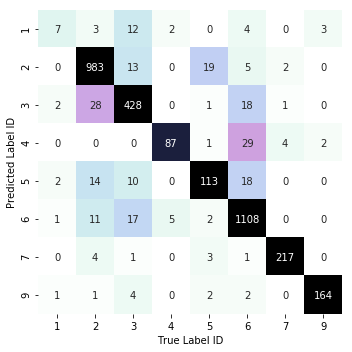

In [28]:

classLabels = ['1', '2', '3', '4', '5', '6', '7', '9']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('True Label ID')
plt.ylabel('Predicted Label ID')

plt.tight_layout()
plt.savefig('confusion_matrix.pdf')

**Feature Importance**

Plots a graph of the 

In [29]:
fitModel = clf.fit(preProcFeats, preProcLabels)

1 longestRun2 0.0188404371275
2 longestRun2 0.0901840241539
3 bestSNR 0.0521147517301
4 MJDstart 0.0479420030506
5 MJDstart 0.043112807747
6 globDedisptsStatsMean 0.0366404368021
7 pixelsMax63 0.0371536757427
8 DMmax 0.0220012785198


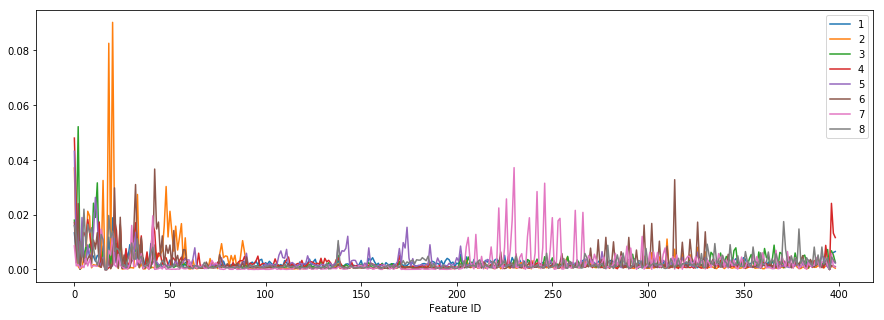

In [30]:
featureStrs = featureDf.columns.values

fimps = []

fig = plt.figure(figsize=(15,5)) # (width, height)
for idx in np.arange(len(fitModel.estimators_)):
    maxFeatVal = fitModel.estimators_[idx].feature_importances_.max() #find the feature with most importance
    
    #plot the importance of each feature (for each estimator, labelled by line colour)
    plt.plot(fitModel.estimators_[idx].feature_importances_, label=idx+1)
    
    #save feature importance array
    fimps.append(fitModel.estimators_[idx].feature_importances_)
    
    #plt.plot(fitModel.estimators_[idx].feature_importances_.clip(1e-2, maxFeatVal), label=idx+1)
    #plt.semilogy(fitModel.estimators_[idx].feature_importances_.clip(1e-3, maxFeatVal), label=idx+1)
    
    #for each estimator 1-8 prints the number, the feature with the highest importance, the features max importance
    print idx+1, featureStrs[np.argmax(fitModel.estimators_[idx].feature_importances_)], maxFeatVal

plt.legend()
plt.xlabel('Feature ID')

In [31]:
print fitModel.predict_proba(preProcFeats)[:10]

[[ 0.          0.          0.          0.          0.          0.          1.
   0.        ]
 [ 0.01162791  0.          0.          0.02325581  0.01162791  0.01162791
   0.93023256  0.01162791]
 [ 0.          0.          0.          0.04705882  0.          0.01176471
   0.94117647  0.        ]
 [ 0.03947368  0.01315789  0.06578947  0.01315789  0.72368421  0.09210526
   0.01315789  0.03947368]
 [ 0.          0.          0.          0.02352941  0.02352941  0.01176471
   0.94117647  0.        ]
 [ 0.04705882  0.          0.          0.          0.          0.01176471
   0.92941176  0.01176471]
 [ 0.          0.          0.          0.04651163  0.          0.02325581
   0.93023256  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.        ]
 [ 0.51578947  0.02105263  0.04210526  0.02105263  0.16842105  0.2         0.
   0.03157895]
 [ 0.          0.          0.          0.01219512  0.01219512  0.
   0.97560976  0.        ]]


In [32]:
predictProb = fitModel.predict_proba(preProcFeats)

(13419,)
(13419, 8)
(691, 1)
0.0877192982456


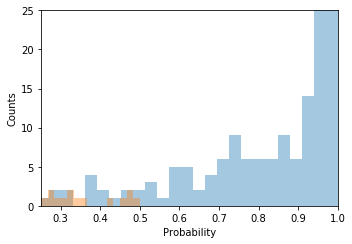

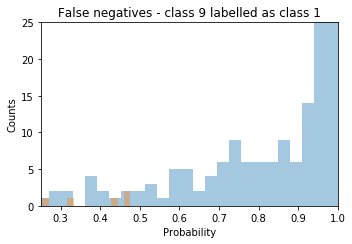

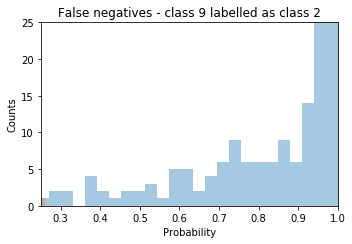

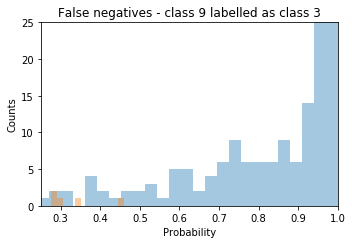

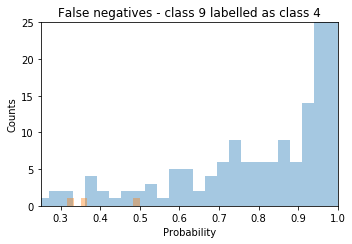

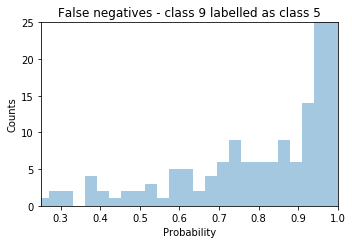

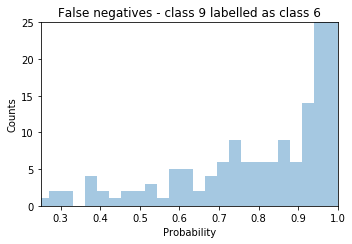

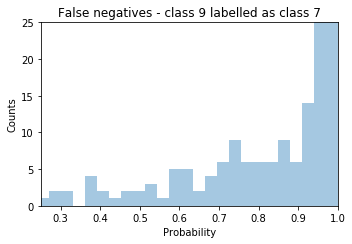

In [42]:
print preProcLabels.shape
print predictProb.shape
print np.argwhere(preProcLabels == 9).shape

#c9c9Prob = predictProb[np.argwhere(preProcLabels == 9).flatten()][:,7]
#cAllc9Prob = predictProb[np.argwhere(preProcLabels != 9).flatten()][:,7]

#fetch probabilities for timeseries that are class 9, and tiemseries that are not class 9 - shouldnt this be 0 and 9?
c9c9Prob = predictTestX[np.argwhere(y_test == 9).flatten()][:,7] #.flatten() collapses the array into one dimension
cAllc9Prob = predictTestX[np.argwhere(y_test != 9).flatten()][:,7]
print c9c9Prob.min()

#fig = plt.figure(figsize=(5,4)) # (width, height)
fig, ax = plt.subplots(figsize=(5,3.5)) # (width, height)
for ss in [c9c9Prob, cAllc9Prob]:
    sns.distplot(ss, kde=False, bins=30)
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.xlim(0.25, 1.)
plt.ylim(0, 25)

plt.tight_layout()
plt.savefig('class9_hist.pdf')

for idx in range(7):
    label = idx+1
    cnc9prob = predictTestX[np.argwhere(y_test == label).flatten()][:,7]
    fig, ax = plt.subplots(figsize=(5,3.5)) # (width, height)
    for ss in [c9c9Prob, cnc9prob]:
        sns.distplot(ss, kde=False, bins=30)
    plt.xlabel('Probability')
    plt.ylabel('Counts')
    plt.xlim(0.25, 1.)
    plt.ylim(0, 25)
    plt.title('False negatives - class 9 labelled as class %s'%label)
    plt.tight_layout()

### The onevsrestclassifier uses a separate estimator for each class, so each of these will have a separate estimator that has different feature importances.

In [34]:
from sklearn.feature_selection import SelectFromModel

highfeats = np.array([])

for estimator in fitModel.estimators_:
    model = SelectFromModel(estimator, prefit=True)
    highfeats = np.append(highfeats, model.get_support(indices = True))

delidx = np.unique(highfeats)
allidx = np.arange(preProcFeats.shape[1])

delfeats = np.delete(allidx, delidx)
highfeats = np.delete(preProcFeats, delfeats, axis=1)
print 'highfeats' + str(highfeats.shape)

highfeats(13419, 328)


/home/inigo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':


#### Redo confusion matrix and importance graph with fewer features

In [35]:
print sklearn.model_selection.cross_val_score(clf, highfeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss')


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(highfeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
predictTestX = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))
print confuseMatrix

[-0.29688434 -0.35670648 -0.30239836]
[[   8    3   13    1    0    5    0    1]
 [   0  985   12    0   19    4    2    0]
 [   1   24  437    0    2   12    1    1]
 [   0    0    1   87    1   30    3    1]
 [   4   12    7    0  115   19    0    0]
 [   1   10   16    4    2 1110    0    1]
 [   0    3    1    0    3    1  218    0]
 [   2    1    3    0    2    2    0  164]]


(8, 8)


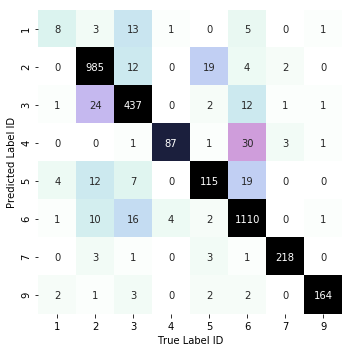

In [36]:
classLabels = ['1', '2', '3', '4', '5', '6', '7', '9']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('True Label ID')
plt.ylabel('Predicted Label ID')

plt.tight_layout()
plt.savefig('confusion_matrix.pdf')

**Feature Importance**

Plots a graph of the 

In [37]:
fitModel = clf.fit(highfeats, preProcLabels)

1 ofCount 0.0171039623105
2 longestRun0 0.101298325835
3 bestSNR 0.0458345590408
4 MJDstart 0.0475608340333
5 MJDstart 0.0398570804714
6 globDedisptsStatsMedian 0.0422493578037
7 windDedispTimeStatsMin12 0.0375865758738
8 BinFactor 0.0279441935596


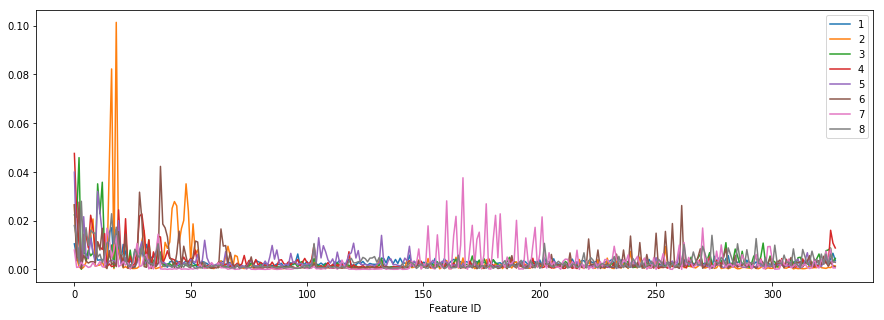

In [38]:
featureStrs = featureDf.columns.values

fimps = []

fig = plt.figure(figsize=(15,5)) # (width, height)
for idx in np.arange(len(fitModel.estimators_)):
    maxFeatVal = fitModel.estimators_[idx].feature_importances_.max() #find the feature with most importance
    
    #plot the importance of each feature (for each estimator, labelled by line colour)
    plt.plot(fitModel.estimators_[idx].feature_importances_, label=idx+1)
    
    #save feature importance array
    fimps.append(fitModel.estimators_[idx].feature_importances_)
    
    #plt.plot(fitModel.estimators_[idx].feature_importances_.clip(1e-2, maxFeatVal), label=idx+1)
    #plt.semilogy(fitModel.estimators_[idx].feature_importances_.clip(1e-3, maxFeatVal), label=idx+1)
    
    #for each estimator 1-8 prints the number, the feature with the highest importance, the features max importance
    print idx+1, featureStrs[np.argmax(fitModel.estimators_[idx].feature_importances_)], maxFeatVal

plt.legend()
plt.xlabel('Feature ID')

In [39]:
print fitModel.predict_proba(highfeats)[:10]

[[ 0.          0.          0.          0.02469136  0.          0.01234568
   0.96296296  0.        ]
 [ 0.          0.          0.          0.01234568  0.01234568  0.
   0.97530864  0.        ]
 [ 0.01204819  0.          0.          0.01204819  0.01204819  0.01204819
   0.95180723  0.        ]
 [ 0.05681818  0.05681818  0.05681818  0.01136364  0.68181818  0.04545455
   0.03409091  0.05681818]
 [ 0.          0.          0.01190476  0.01190476  0.01190476  0.01190476
   0.95238095  0.        ]
 [ 0.0125      0.          0.          0.          0.          0.          0.975
   0.0125    ]
 [ 0.          0.          0.          0.03614458  0.          0.01204819
   0.95180723  0.        ]
 [ 0.          0.          0.          0.025       0.          0.          0.975
   0.        ]
 [ 0.57425743  0.03960396  0.02970297  0.03960396  0.16831683  0.10891089
   0.00990099  0.02970297]
 [ 0.0125      0.          0.          0.          0.          0.          0.9875
   0.        ]]


In [40]:
predictProb = fitModel.predict_proba(highfeats)

(13419,)
(13419, 8)
(691, 1)
0.0877192982456


/home/inigo/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


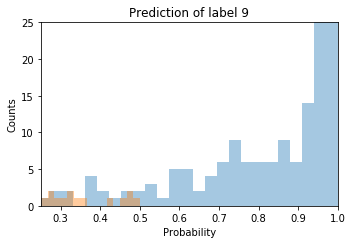

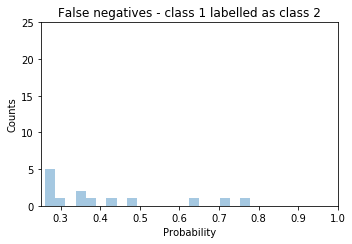

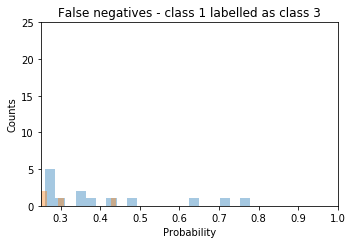

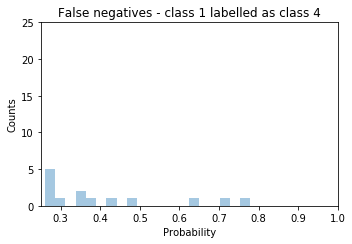

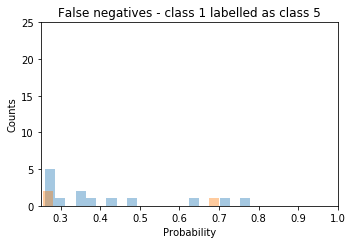

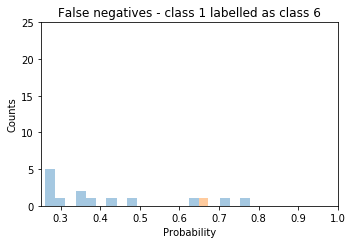

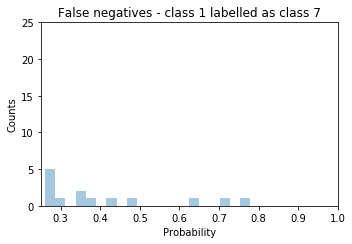

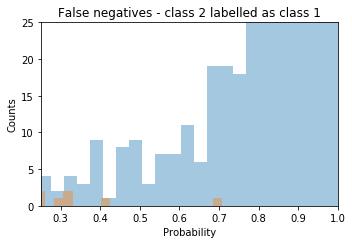

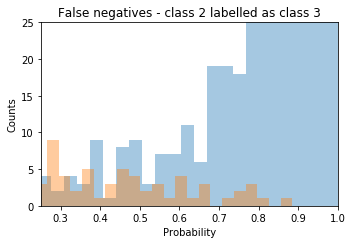

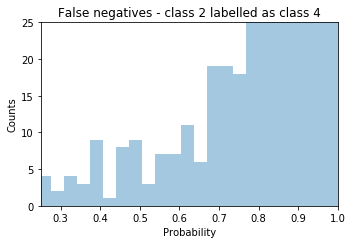

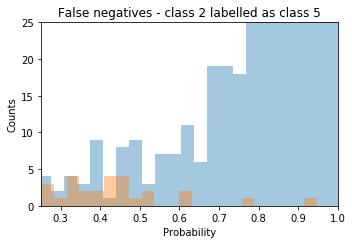

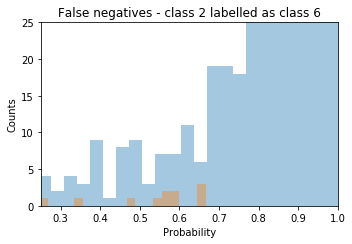

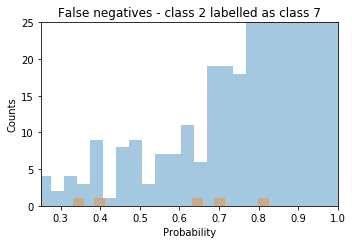

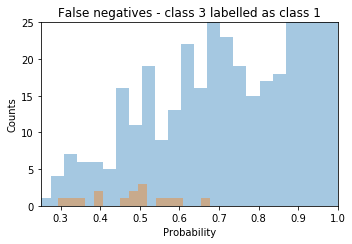

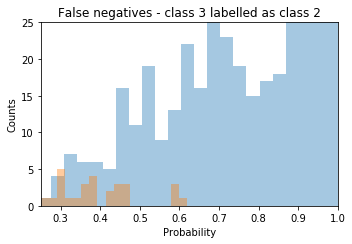

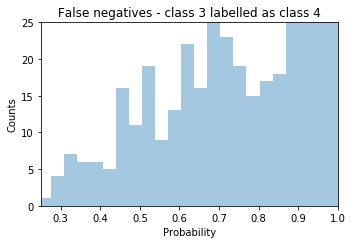

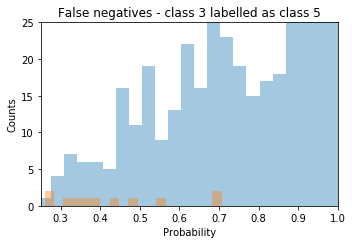

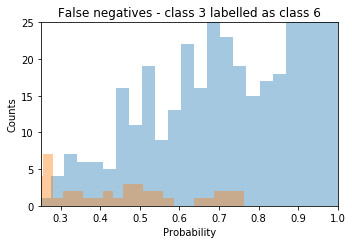

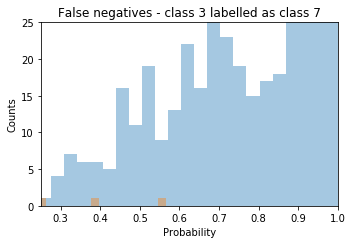

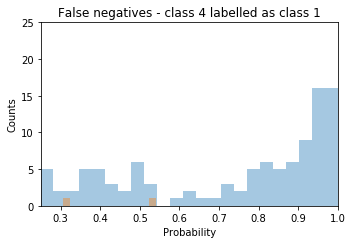

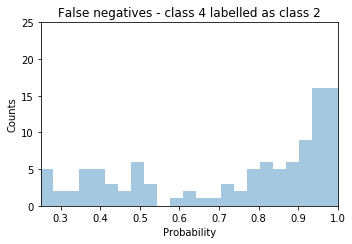

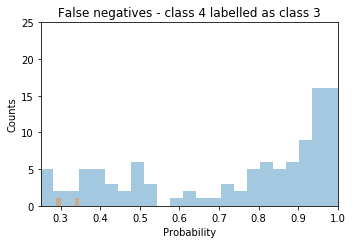

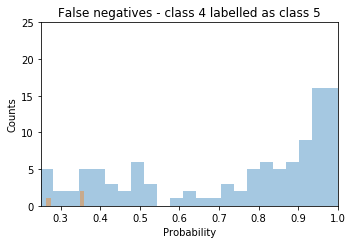

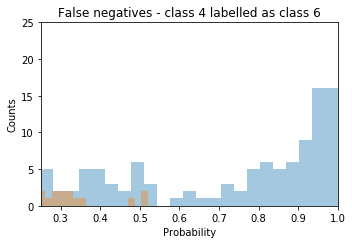

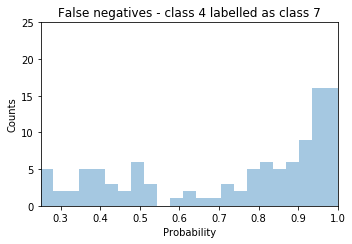

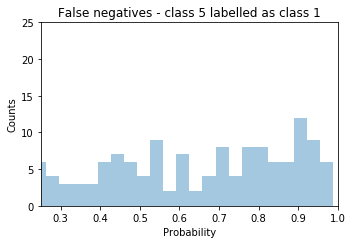

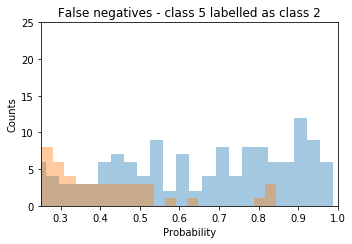

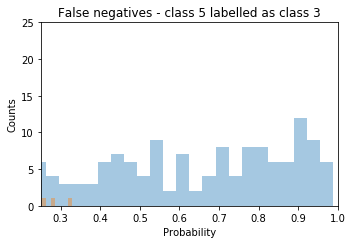

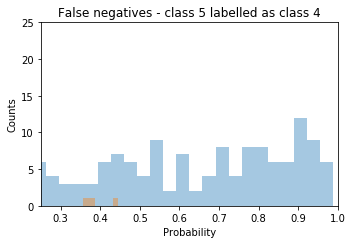

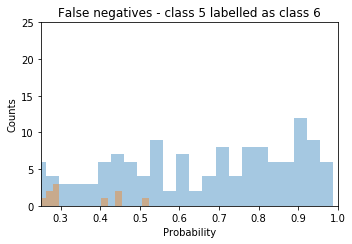

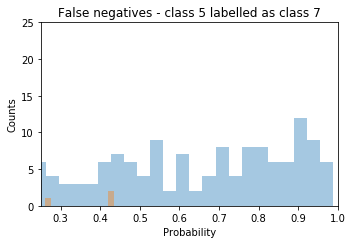

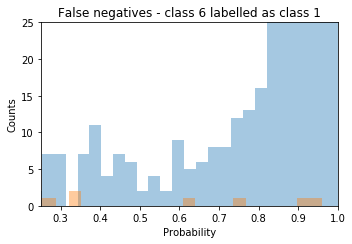

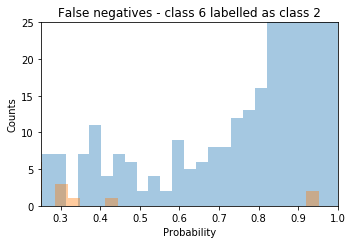

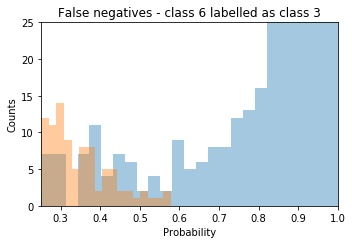

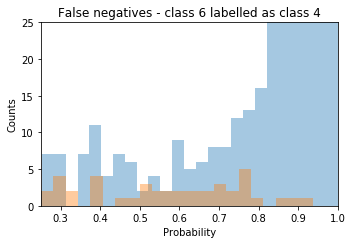

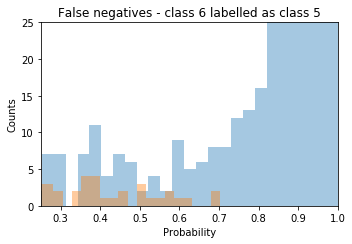

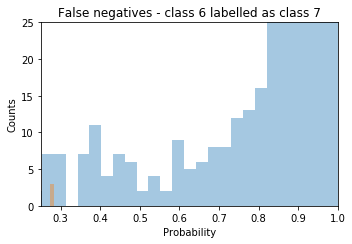

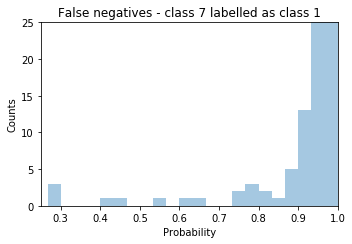

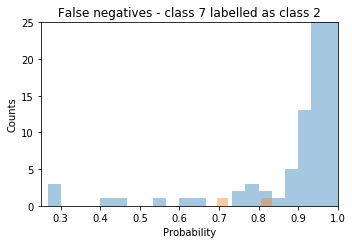

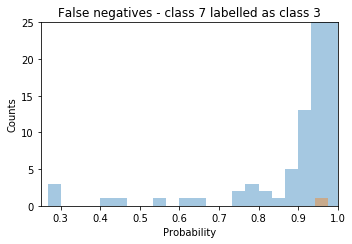

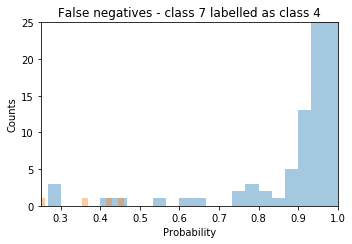

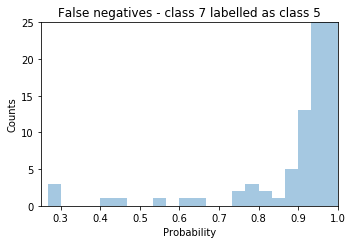

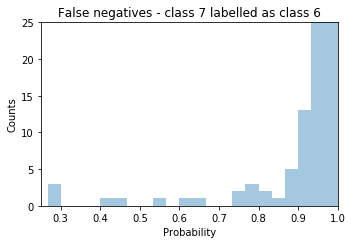

In [41]:
print preProcLabels.shape
print predictProb.shape
print np.argwhere(preProcLabels == 9).shape

#c9c9Prob = predictProb[np.argwhere(preProcLabels == 9).flatten()][:,7]
#cAllc9Prob = predictProb[np.argwhere(preProcLabels != 9).flatten()][:,7]

#fetch probabilities for timeseries that are class 9, and tiemseries that are not class 9 - shouldnt this be 0 and 9?
c9c9Prob = predictTestX[np.argwhere(y_test == 9).flatten()][:,7] #.flatten() collapses the array into one dimension
cAllc9Prob = predictTestX[np.argwhere(y_test != 9).flatten()][:,7]
print c9c9Prob.min()




#fig = plt.figure(figsize=(5,4)) # (width, height)
fig, ax = plt.subplots(figsize=(5,3.5)) # (width, height)
for ss in [c9c9Prob, cAllc9Prob]:
    sns.distplot(ss, kde=False, bins=30)
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.title('Prediction of label 9')
plt.xlim(0.25, 1.)
plt.ylim(0, 25)

plt.tight_layout()
plt.savefig('Figures/class9_hist.pdf')

for i in range(7):
    truelabel = i+1
    for idx in range(7):
        if idx != i:
            predlabel = idx+1
            cncnProb = predictTestX[np.argwhere(y_test == truelabel).flatten()][:,i]
            cnciprob = predictTestX[np.argwhere(y_test == predlabel).flatten()][:,i]
            fig, ax = plt.subplots(figsize=(5,3.5)) # (width, height)
            for ss in [cncnProb, cnciprob]:
                sns.distplot(ss, kde=False, bins=30)
            plt.xlabel('Probability')
            plt.ylabel('Counts')
            plt.xlim(0.25, 1.)
            plt.ylim(0, 25)
            plt.title('False negatives - class %d labelled as class %d'%(truelabel ,predlabel))
            plt.tight_layout()
            plt.savefig('Figures/Label%dPred%d'%(truelabel, predlabel))